In [1]:
import torch
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm, trange
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

import os, sys, re, gc, glob
from tqdm.auto import tqdm, trange
from utils import JDIDataset, JDIModel, get_grey_image, assign_labels, accuracy



import seaborn as sns

2021-05-22 18:03:10,026 -INFO - config:config.py:16 - Module utils.config was loaded
2021-05-22 18:03:10,026 -INFO - common:common.py:561 - Module utils.common is loaded...
2021-05-22 18:03:10,026 -INFO - dataset_builder:dataset_builder.py:244 - dataset package is loaded...
2021-05-22 18:03:10,042 -INFO - dataset:dataset.py:627 - dataset package is loaded...


In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [3]:
DEVICE='cpu'

In [4]:
model = torch.load('model/model.pth').to(DEVICE)
model.eval()

JDIModel(
  (input_layer): Linear(in_features=5489, out_features=64, bias=False)
  (batchNorm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.1, inplace=True)
  (hidden1): Linear(in_features=64, out_features=32, bias=False)
  (batchNorm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.1, inplace=True)
  (hidden2): Linear(in_features=32, out_features=22, bias=True)
)

## Load test dataset

In [5]:
dataset_name = 'cnews'


In [6]:
dataset = JDIDataset(dataset_names=[dataset_name], rebalance=False)

2021-05-22 18:03:12,256 -INFO - dataset:dataset.py:235 - List of dataset_names:['cnews']
2021-05-22 18:03:12,257 -INFO - dataset:dataset.py:241 - Dataset for cnews
2021-05-22 18:03:12,394 -INFO - dataset:dataset.py:243 - Dataset shape: (2223, 13)
2021-05-22 18:03:12,394 -INFO - dataset:dataset.py:245 - cleaning tag_name from dummy/auxiliary words
2021-05-22 18:03:12,394 -INFO - dataset:dataset.py:44 - select all leafs (nodes which are not parents)
2021-05-22 18:03:12,399 -INFO - dataset:dataset.py:47 - Leafs set size: 1326 (nodes which have no children)
2021-05-22 18:03:12,401 -INFO - dataset:dataset.py:50 - count number of references to leafs
2021-05-22 18:03:12,403 -INFO - dataset:dataset.py:54 - Nodes with leafs as children set size: 671 (nodes which have leafs as children)
2021-05-22 18:03:12,405 -INFO - dataset:dataset.py:57 - count num children for each node
2021-05-22 18:03:12,406 -INFO - dataset:dataset.py:59 - Nodes with children: 898
2021-05-22 18:03:12,408 -INFO - dataset:da

  0%|          | 0/2223 [00:00<?, ?it/s]

2021-05-22 18:03:16,415 -INFO - dataset:dataset.py:260 - Dataset shape after merging with parents: (2223, 44)
2021-05-22 18:03:16,415 -WARNING - dataset:dataset.py:275 - assign dummy values [n/a] for labels if there is no annotations
2021-05-22 18:03:16,471 -INFO - dataset:dataset.py:282 - Concatenate datasets
2021-05-22 18:03:16,477 -INFO - dataset:dataset.py:284 - Dataset shape after reading: (2223, 46)
2021-05-22 18:03:16,480 -WARNING - dataset:dataset.py:607 - Loading count vectorizer for column "cv_class": model/count_vectorizer_class.pkl
2021-05-22 18:03:16,489 -INFO - dataset:dataset.py:624 - class_sm: (2223, 949)
2021-05-22 18:03:16,490 -INFO - dataset:dataset.py:293 - Build OHE column for attribute role
2021-05-22 18:03:16,494 -INFO - dataset:dataset.py:293 - Build OHE column for attribute type
2021-05-22 18:03:16,496 -INFO - dataset:dataset.py:293 - Build OHE column for attribute ui
2021-05-22 18:03:16,500 -INFO - dataset:dataset.py:298 - Build OHE column for attribute role_p

In [7]:
dataset.dataset.shape

(2223, 55)

In [8]:
dataset.labels

0       n/a
1       n/a
2       n/a
3       n/a
4       n/a
       ... 
2218    n/a
2219    n/a
2220    n/a
2221    n/a
2222    n/a
Name: label, Length: 2223, dtype: object

In [9]:
dataset.dataset.label

0       21
1       21
2       21
3       21
4       21
        ..
2218    21
2219    21
2220    21
2221    21
2222    21
Name: label, Length: 2223, dtype: int32

In [10]:
dataloader=DataLoader(dataset, shuffle=False, batch_size=1, collate_fn=dataset.collate_fn, pin_memory=True)

In [11]:
results = []
with trange(len(dataloader)) as bar:
    with torch.no_grad():
        for x, y in dataloader:
           
            y_pred = torch.round(torch.nn.Softmax(dim=1)(model(x.to(DEVICE)).to('cpu'))).detach().numpy()
            y_pred = y_pred[0].argmax()
            y = y.item()           
            
            results.append({
                'y_true': y,
                'y_pred': y_pred,
                'y_true_label': dataset.classes_reverse_dict[y], 
                'y_pred_label': dataset.classes_reverse_dict[y_pred]
            })
            bar.update(1)

results_df = pd.DataFrame(results)
results_df

  0%|          | 0/2223 [00:00<?, ?it/s]

,y_true,y_pred,y_true_label,y_pred_label
0,21,0,n/a,button
1,21,21,n/a,n/a
2,21,21,n/a,n/a
3,21,21,n/a,n/a
4,21,21,n/a,n/a
...,...,...,...,...
2218,21,21,n/a,n/a
2219,21,21,n/a,n/a
2220,21,21,n/a,n/a
2221,21,21,n/a,n/a


In [12]:
list(dataset.classes_dict.keys())

['button',
 'link',
 'iframe',
 'textfield',
 'dropdown',
 'checkbox_btn',
 'checkbox_label',
 'radiobutton_btn',
 'radiobutton_label',
 'textarea',
 'text',
 'fileinput',
 'image',
 'colorpicker',
 'range',
 'progressbar',
 'datetimeselector',
 'numberselector',
 'dropdownselector',
 'checklist',
 'table',
 'n/a']

In [13]:
confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_true=results_df.y_true_label.values,
                     y_pred=results_df.y_pred_label.values, 
                     labels=list(dataset.classes_dict.keys())
                    ), 
    columns=list(dataset.classes_dict.keys()),
    index=list(dataset.classes_dict.keys())
)



In [14]:
confusion_matrix_df

,button,link,iframe,textfield,dropdown,checkbox_btn,checkbox_label,radiobutton_btn,radiobutton_label,textarea,...,image,colorpicker,range,progressbar,datetimeselector,numberselector,dropdownselector,checklist,table,n/a
button,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
link,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
iframe,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
textfield,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dropdown,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
checkbox_btn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
checkbox_label,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
radiobutton_btn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
radiobutton_label,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
textarea,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
import seaborn as sns


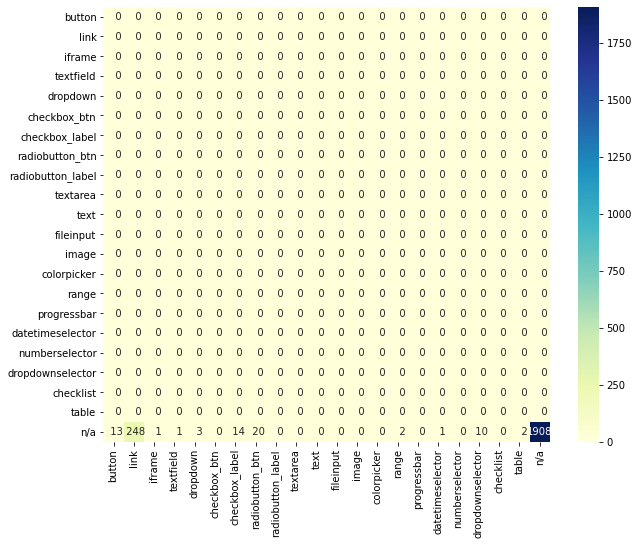

In [16]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix_df, annot=True, fmt="4d", cmap="YlGnBu");

In [17]:
dataset_name

'cnews'

In [18]:
accuracy(results_df)

2021-05-22 18:03:20,605 -INFO - common:common.py:438 - Accuracy:  0/315 = 0.0, for 2223 elements


0.0

In [19]:
dataset.classes_dict

{'button': 0,
 'link': 1,
 'iframe': 2,
 'textfield': 3,
 'dropdown': 4,
 'checkbox_btn': 5,
 'checkbox_label': 6,
 'radiobutton_btn': 7,
 'radiobutton_label': 8,
 'textarea': 9,
 'text': 10,
 'fileinput': 11,
 'image': 12,
 'colorpicker': 13,
 'range': 14,
 'progressbar': 15,
 'datetimeselector': 16,
 'numberselector': 17,
 'dropdownselector': 18,
 'checklist': 19,
 'table': 20,
 'n/a': 21}

In [20]:

dataset.dataset['label_text_predicted'] = results_df.y_pred_label


(7900, 1500)


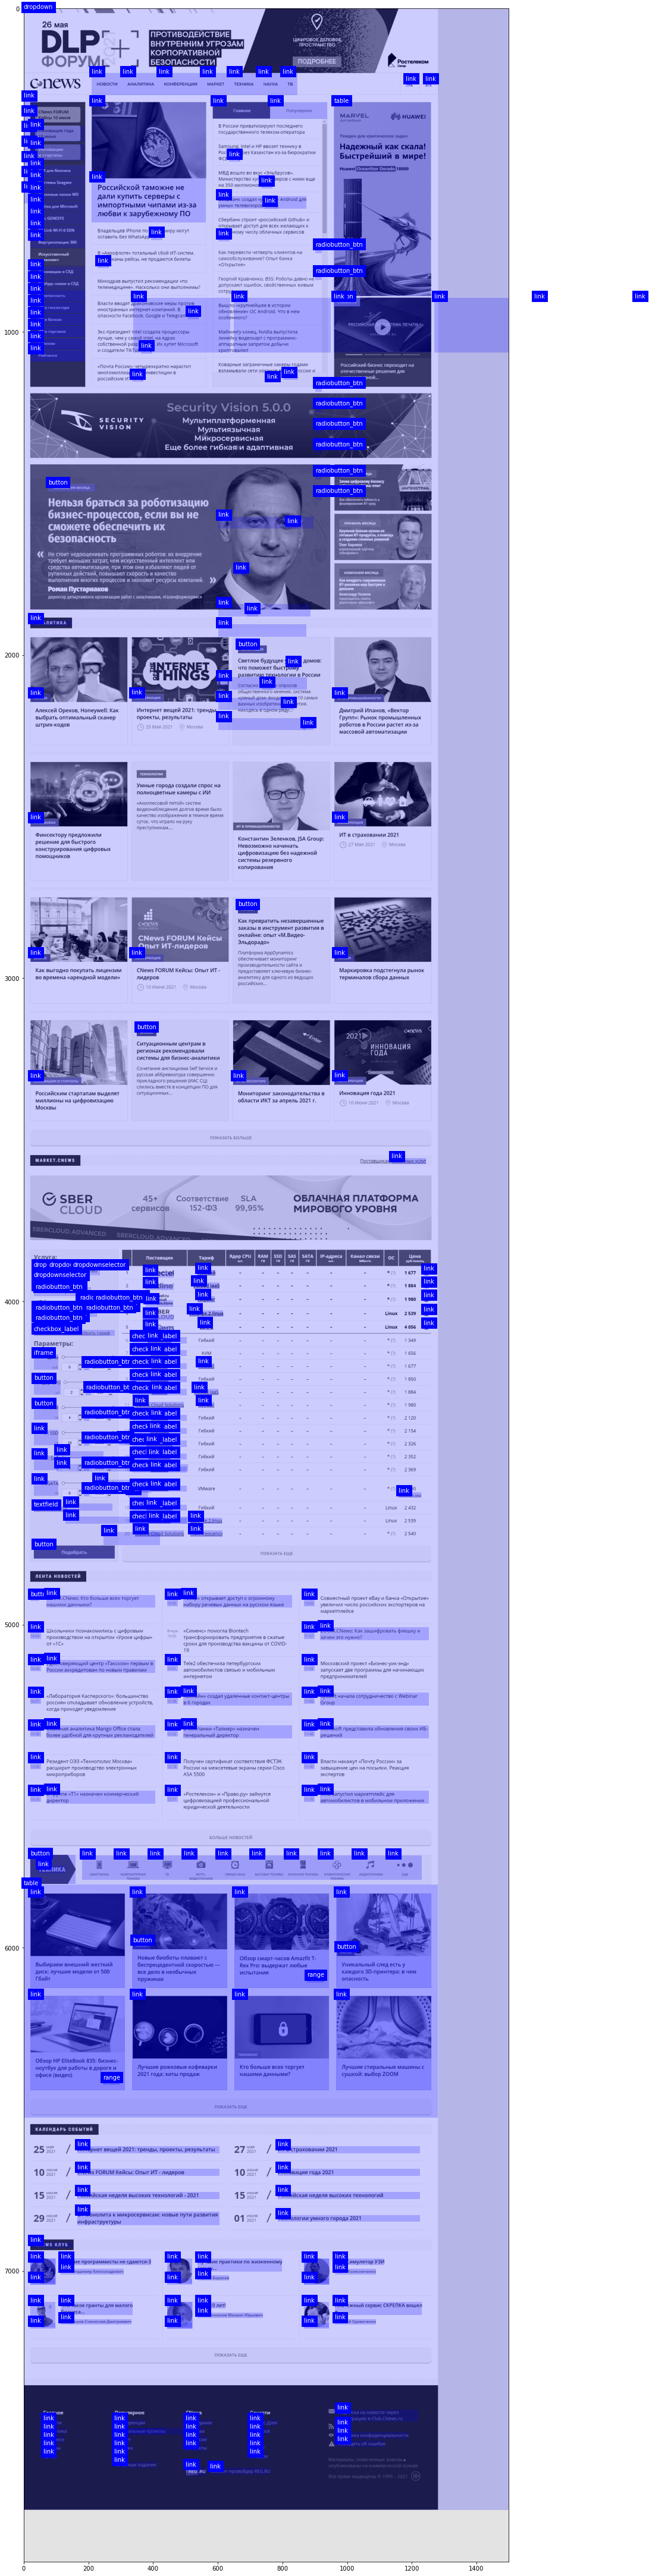

In [21]:
gray_img = get_grey_image(f'dataset/images/{dataset_name}.png')
print(gray_img.shape)

IMG_SIZE = 15
_h = gray_img.shape[0]/gray_img.shape[1]*IMG_SIZE
_w = IMG_SIZE
plt.figure(figsize=(_w, _h))

plt.imshow(gray_img, cmap='gray')
axes = plt.gca()

for i, r in dataset.dataset[dataset.dataset.label_text_predicted != 'n/a'].iterrows():
    #print(r.predicted_label, r.x, r.y, r.width, r.height)
    
    if (r.x<0) or (r.y<0): # or (r.x>r.width): #or (r.y>r.height):
        continue
        
    patch = Rectangle((r.x, r.y), r.width, r.height, linewidth=2, alpha = .2, facecolor = 'blue')
    axes.add_patch(patch)
    axes.text(r.x, r.y, r.label_text_predicted, color='white', backgroundcolor='blue')

for i, r in dataset.dataset[dataset.dataset.label != dataset.dummy_class_value].iterrows():
    #print(r.predicted_label, r.x, r.y, r.width, r.height)
    patch = Rectangle((r.x, r.y), r.width, r.height, linewidth=2, alpha = .2, facecolor = 'red')
    axes.add_patch(patch)
    axes.text(r.x+15, r.y+15, dataset.classes_reverse_dict[r.label], color='white', backgroundcolor='red')
    




In [22]:
results_df

,y_true,y_pred,y_true_label,y_pred_label
0,21,0,n/a,button
1,21,21,n/a,n/a
2,21,21,n/a,n/a
3,21,21,n/a,n/a
4,21,21,n/a,n/a
...,...,...,...,...
2218,21,21,n/a,n/a
2219,21,21,n/a,n/a
2220,21,21,n/a,n/a
2221,21,21,n/a,n/a


In [23]:
dataset.dataset[:1].to_json(orient='records')

'[{"attributes":{"action":null,"alt":null,"aria-hidden":null,"aria-label":null,"aria-live":null,"aria-relevant":null,"async":null,"cellspacing":null,"charset":null,"checked":null,"class":null,"content":null,"crossorigin":null,"data-advert":null,"data-category":null,"data-char":null,"data-cnb":null,"data-comment":null,"data-dismiss":null,"data-filter":null,"data-id":null,"data-input":null,"data-next-page-url":null,"data-nocomment":null,"data-number":null,"data-page":null,"data-result":null,"data-search":null,"data-service":null,"data-show-id":null,"data-show-type":null,"data-src":null,"data-step":null,"data-style":null,"data-tariff":null,"data-toggle":null,"data-type":null,"data-zone":null,"defer":null,"for":null,"frameborder":null,"height":null,"href":null,"http-equiv":null,"id":null,"integrity":null,"max":null,"media":null,"method":null,"min":null,"name":null,"onclick":null,"placeholder":null,"property":null,"rel":null,"role":null,"sandbox":null,"scrolling":null,"selected":null,"src":